In [92]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.selectors import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [ ]:
toload = [ 
    # dict(name="base", id="upst1ai-strumpack_Tnorm_x10_match_fluxlim", unnormalise = True), 
    # dict(name="new", id="upst5a-reimplement_AFN_from_upst1ah", unnormalise = True), 
    dict(name="base", id="upst5a-new_ena_hflim1_maxmfp_0.1_multispecies_econd", unnormalise = True), 
    dict(name="Nnorm_x10", id="upst5ab-Nnorm_x10", unnormalise = True), 
    # dict(name="brag", id="upst5b-braginskii_everything", unnormalise = True), 
    
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = False, verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case upst5b-braginskii_everything
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


/home/mike/work/sdtools/hermes3/plotting.py:760: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


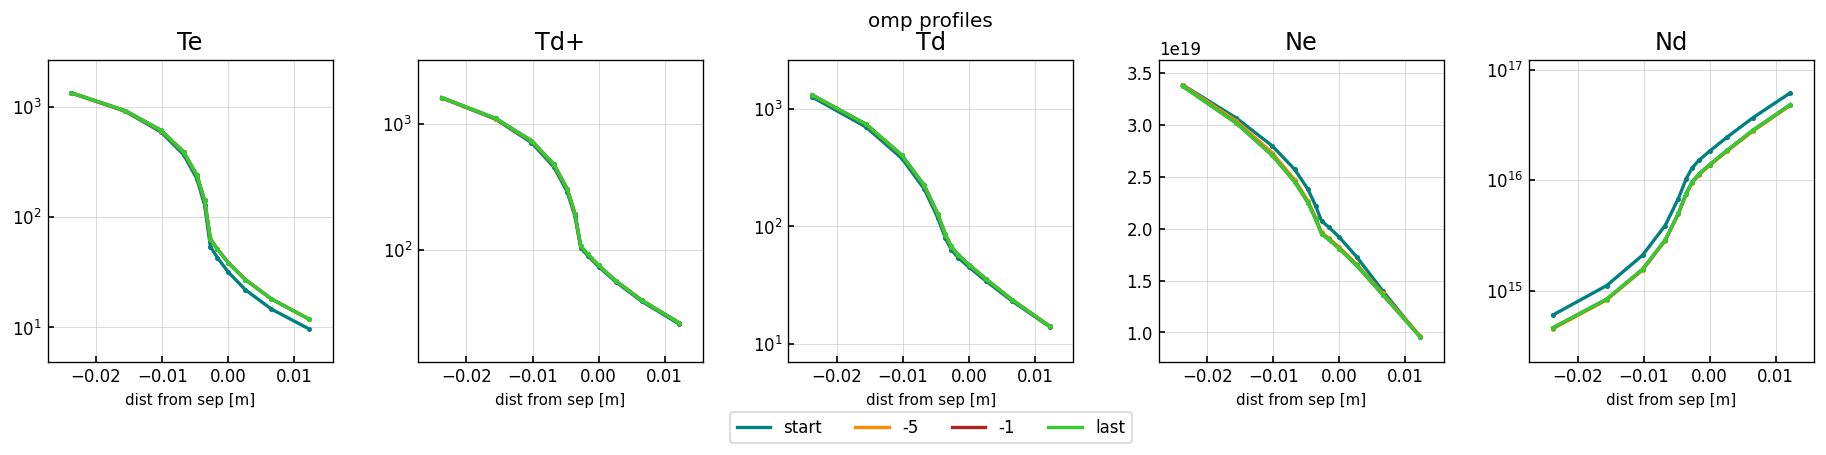

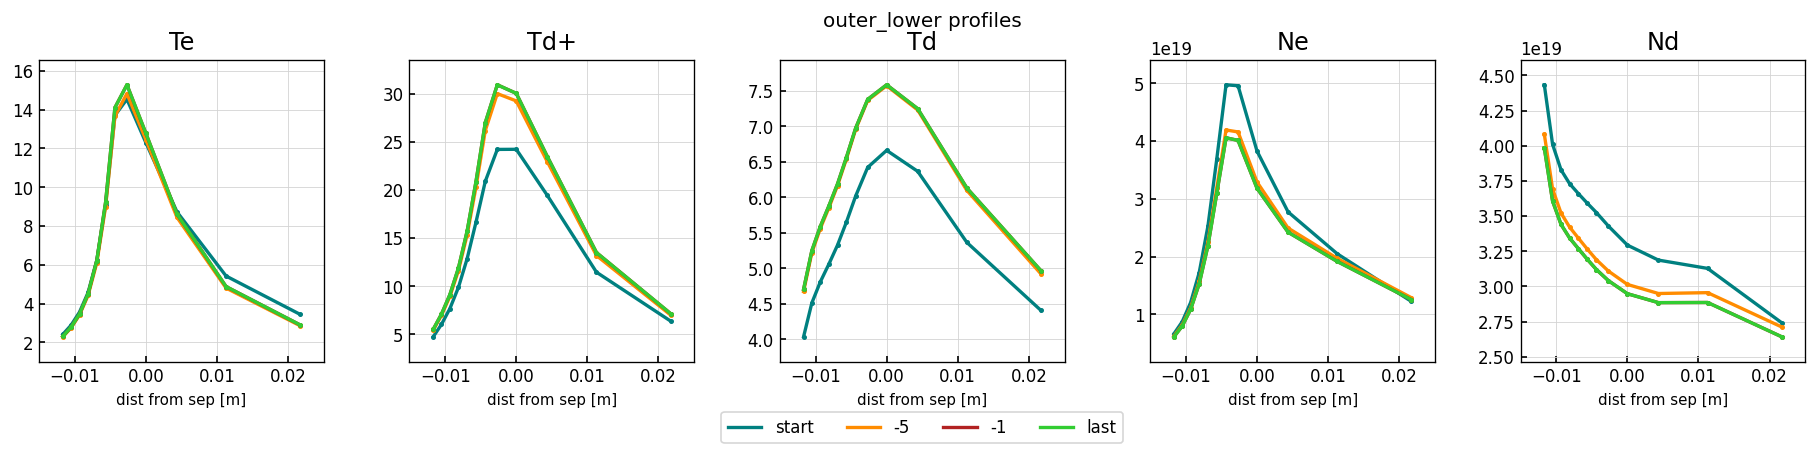

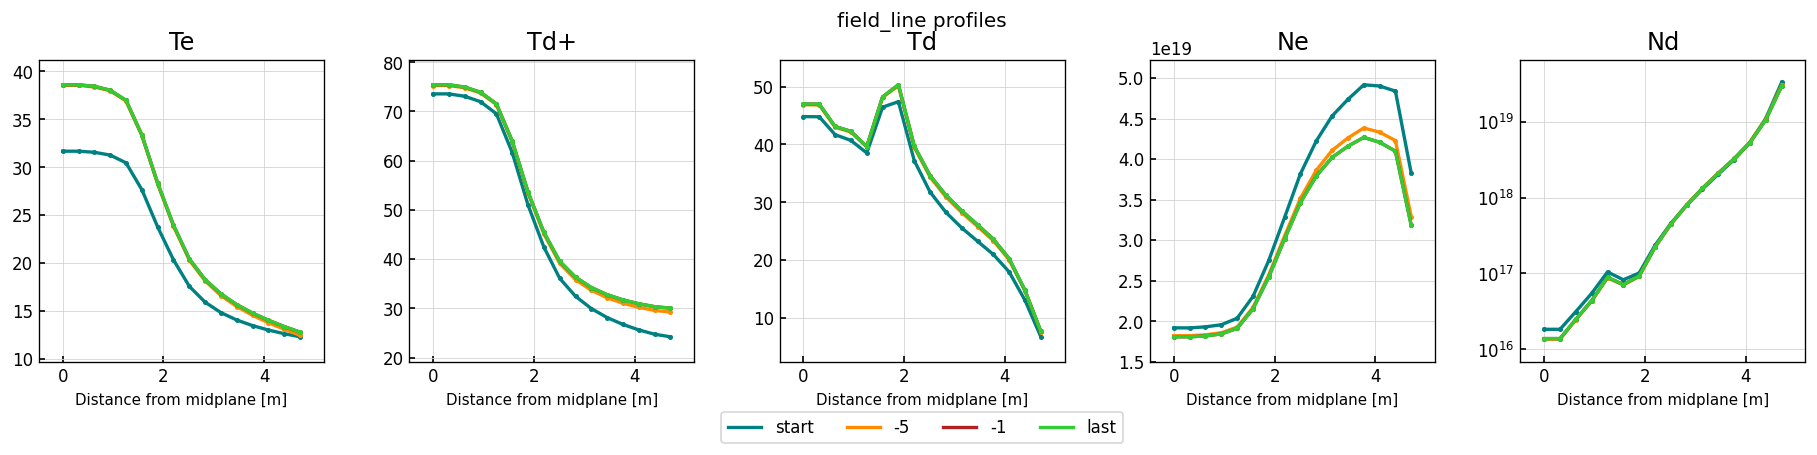

In [4]:
case = "base"
lineplot(
    {
        "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        "-5":cs[case].ds.isel(t=-5, x = slice(2,-2)),
        "-1":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

/home/mike/work/sdtools/hermes3/plotting.py:760: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


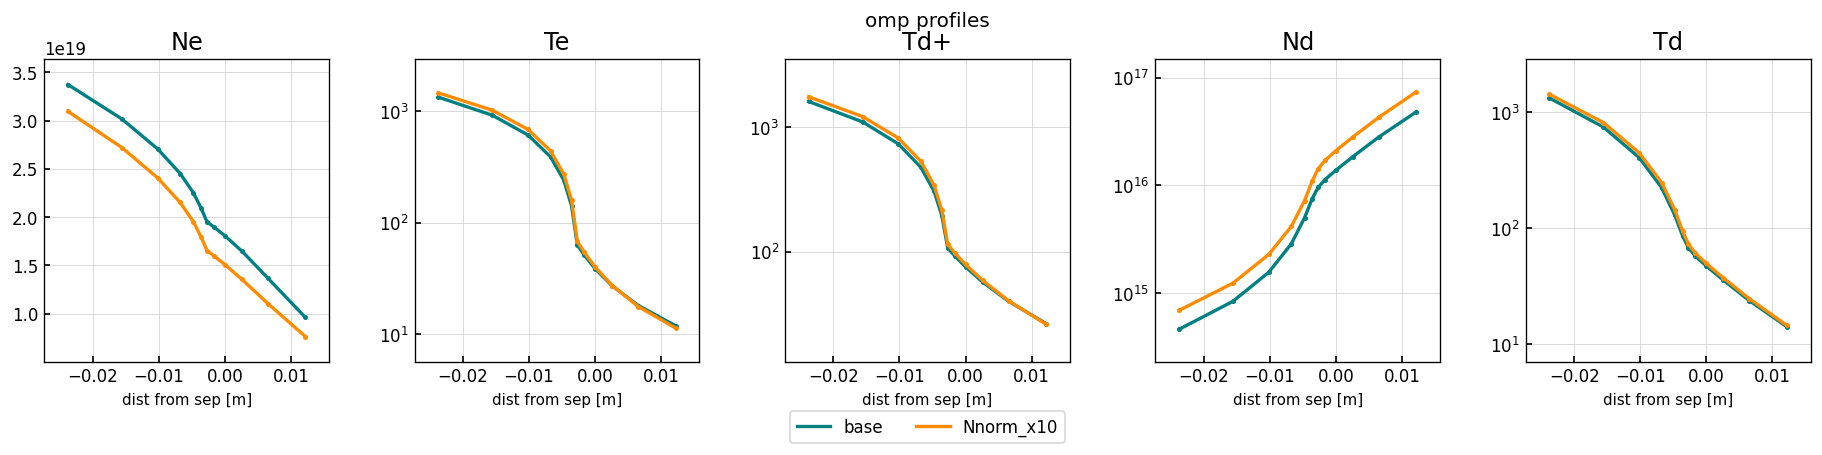

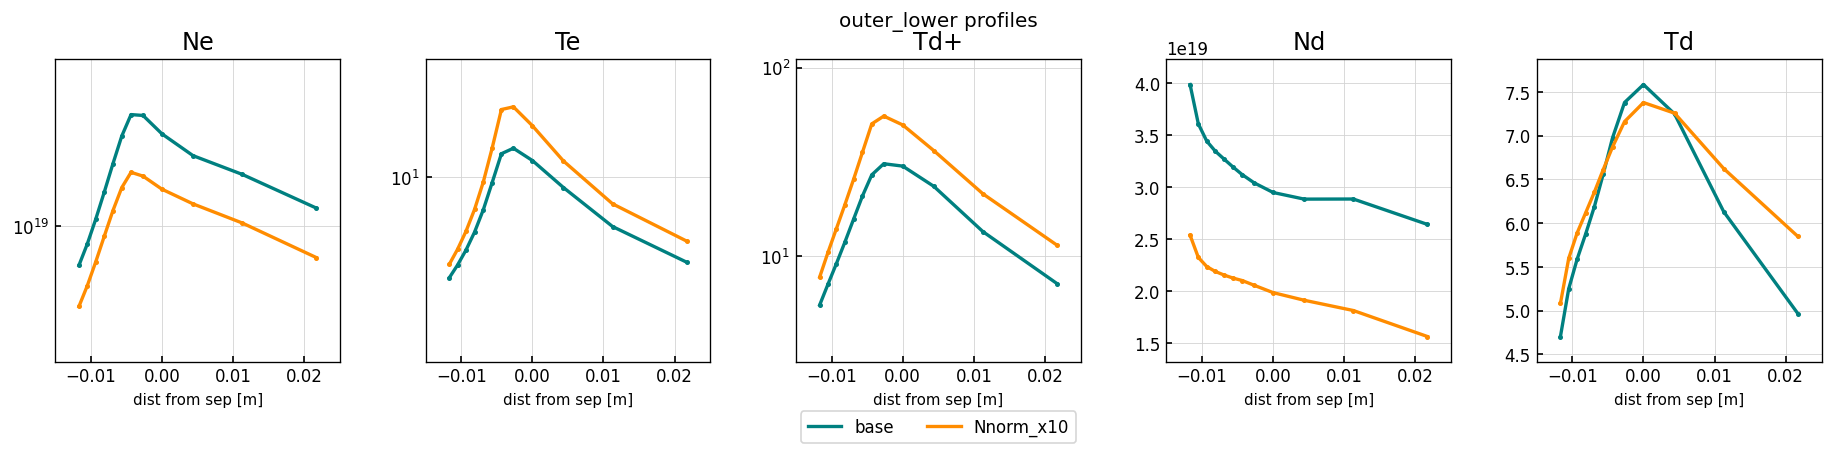

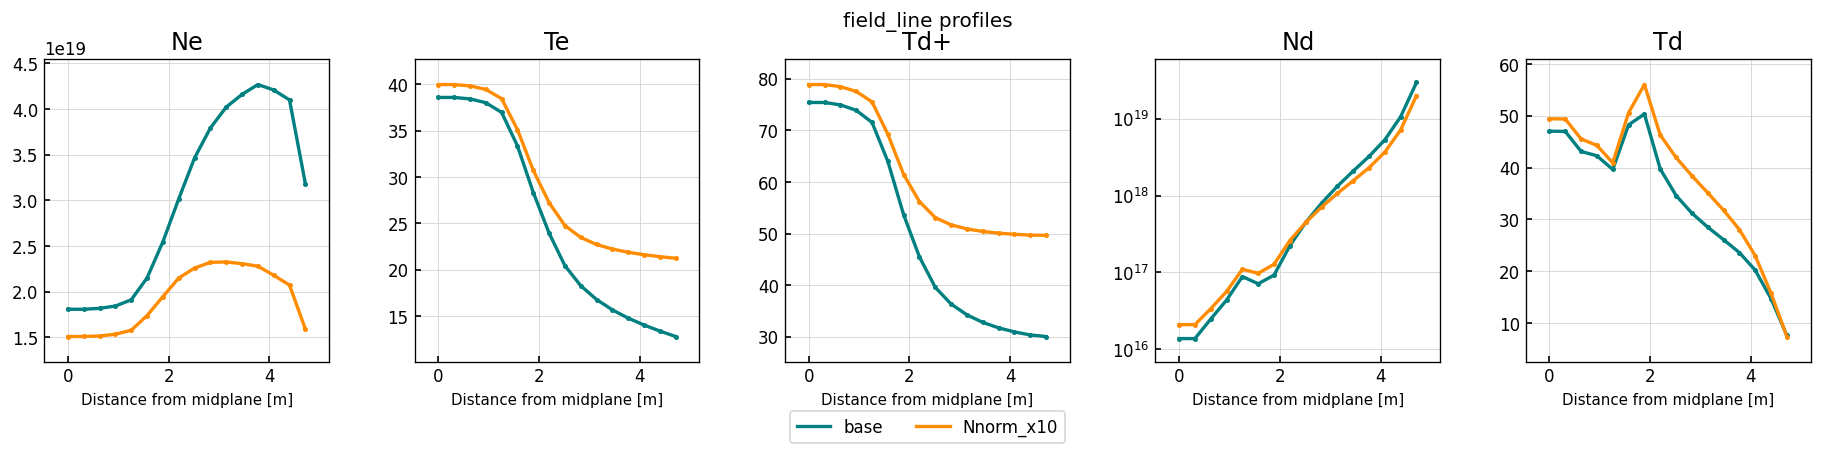

In [4]:
toplot = {}
for case in cs:
# for case in ["test_legacy", "test_afn"]:

    ds = cs[case].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    toplot[case] = ds.isel(x = slice(2,-2))
    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # params = ["Nd", "Dnnd"],
    regions = ["omp", "outer_lower", "field_line"],
)

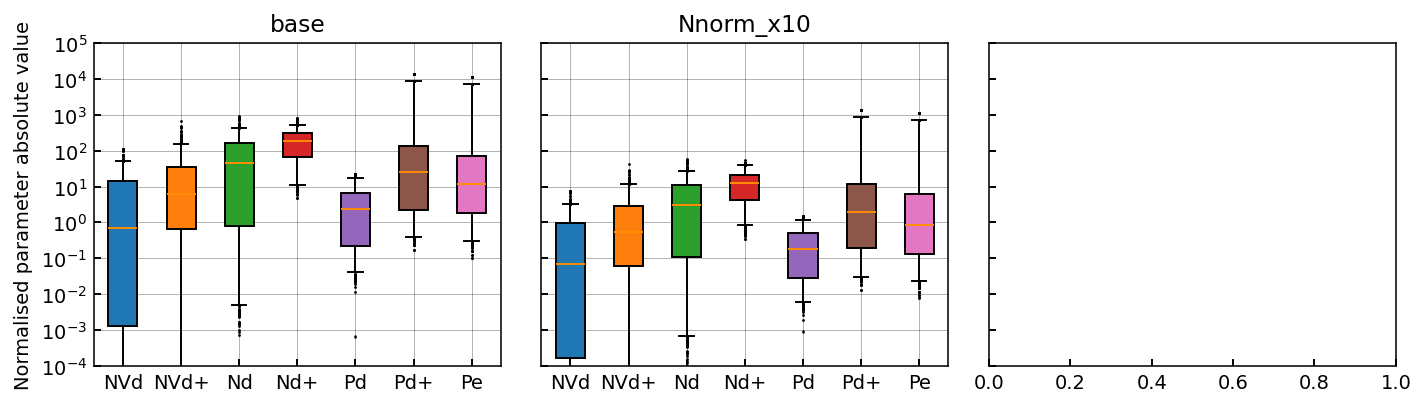

In [5]:
fig, axes = plt.subplots(1,3, figsize = (3*4,3), sharey = True)

for i, name in enumerate(cs):
    ds = cs[name].ds
    if "t" in ds.sizes: ds = ds.isel(t=-1)
    
    
    ax = axes[i]
    plot_variable_magnitude(ds, ax = ax, ylims = (1e-4, 1e5))
    ax.set_title(name)
    if i > 0:
        ax.set_ylabel("")
    ax.grid(color = "k", alpha = 0.3)
        
fig.subplots_adjust(wspace = 0.1)

In [6]:
cs.keys()

dict_keys(['base', 'Nnorm_x10'])

/home/mike/pyenvs/base-3.12.5/lib/python3.12/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


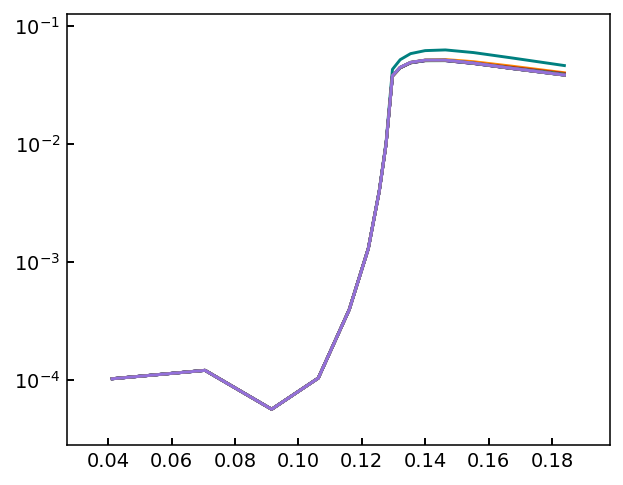

In [74]:
name = "base"

param = "Pe"

ds = cs[name].ds
ds[f"{param}_diff"] = ds["Pe"].diff(dim="t")
ds[f"{param}_diff_rms"] = np.sqrt((ds["Pe_diff"]**2).mean(dim="t"))
ds[f"{param}_diff_rms_rel"] = ds[f"{param}_diff_rms"] / ds["Pe"]

fig, ax = plt.subplots()

# df = get_1d_radial_data(ds, [f"{param}_diff_rms",f"{param}_diff_rms_rel"], "imp")

sel = {"x":slice(2,-2), "theta":9}
ds_slice = ds[sel]

x = ds_slice["dr"].cumsum()
ax.plot(x, ds_slice[f"{param}_diff_rms_rel"])
ax.set_yscale("log")

In [79]:
ds[f"{param}_diff_rms"].sizes

Frozen({'x': 20, 'theta': 58})

In [91]:
%matplotlib tk

ImportError: Cannot load backend 'qtagg' which requires the 'qt' interactive framework, as 'headless' is currently running

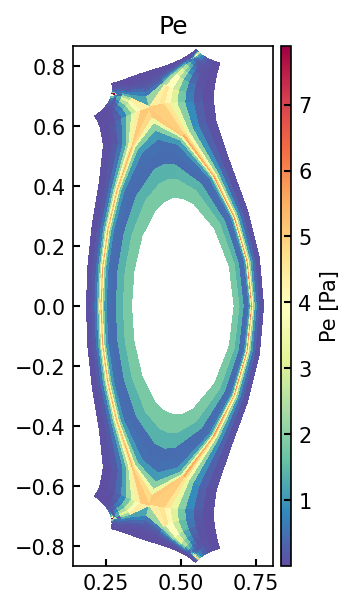

In [88]:


cmap = "Spectral_r"

name = "base"

ds = cs[name].ds
params = ["Nd+", "Nd", "Pe", "Pd+", "Pd", "NVd+", "NVd"]

params = ["Pe"]

no_params = len(params)
fig, axes = plt.subplots(1,no_params, figsize = (3.0*no_params,4.5), dpi = 150)
if no_params == 1:
  axes = [axes]

for i, param in enumerate(params):
  
  da_param = ds[param]
  ddt_param = ds[f"ddt({param})"]
  if "t" in ds.sizes:
    # fluctuations = np.sqrt((ds[ddt_param]**2).mean(dim="t"))
    
    diff = da_param.diff(dim="t")
    reldiff = diff/da_param
    rms = np.sqrt((diff**2).mean(dim="t"))

  else:
    print("WARNING: NO TIME!")

  # data = da_param * fluctuations
  # data = ds[param]
  data = rms
  
  ax = axes[i]
  data.hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 0),
                                                        antialias = False,
                                                        logscale = False,
                                                        # vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                        )
  ax.set_title(param)
  ax.set_xlabel("")
  ax.set_ylabel("")

In [ ]:
np.set_printoptions(threshold=np.inf)
data.values

In [48]:
ratio = fluctuations.values / da_param.values

for i in ratio.flatten():
    print(i)

0.015040403185012647
0.0196785477115673
0.005161501412694228
0.015040403185012638
0.011853792245672849
0.004078472285418618
0.005310705336901172
0.00012103526998382983
0.00012215093197485622
0.00012100433696933477
0.0001221308394708733
0.00012098178088399486
0.00012212518029593278
0.00012098791963214298
0.00012214852516953602
0.00012100848274423154
0.0001221805048424217
0.005500179844798922
0.0037082732916100323
0.011336403688796879
0.01472486282487969
0.0051407309621551945
0.019105134286622555
0.014724862824879678
0.01762185305402199
0.029497239059496368
0.023512730263341778
0.017621853054022005
0.0116852244878078
0.0066819495914544535
0.004304496303192081
0.0062616866666467515
0.00919618610350755
0.010027978713327243
0.006092010456661855
0.009783370457810438
0.00012103374404264087
0.00012222342358511582
0.00012109546261557553
0.00012221623839396616
0.00012106031377171289
0.00012220397111992588
0.00012107142408408341
0.0001222376843942211
0.00012107722823716893
0.0001221763295482336
0

In [42]:
if "t" in ds.sizes: ds = ds.isel(t=-1)

# da = ds["Pe"]
da = data
bad_mask = (da.isnull() | (da < 0)).compute()
bad = da.where(bad_mask, drop=True)   # keeps coords of offending points

bad.values
# da.where(da < 0).compute().values.dropna()
# ds["Pe"].isnull()

array([], shape=(0, 0, 0), dtype=float64)

In [14]:
ds["Pe"].where(ds["Pe"]<0, drop = True)

KeyError: 'Indexing with a boolean dask array is not allowed. This will result in a dask array of unknown shape. Such arrays are unsupported by Xarray.Please compute the indexer first using .compute()'

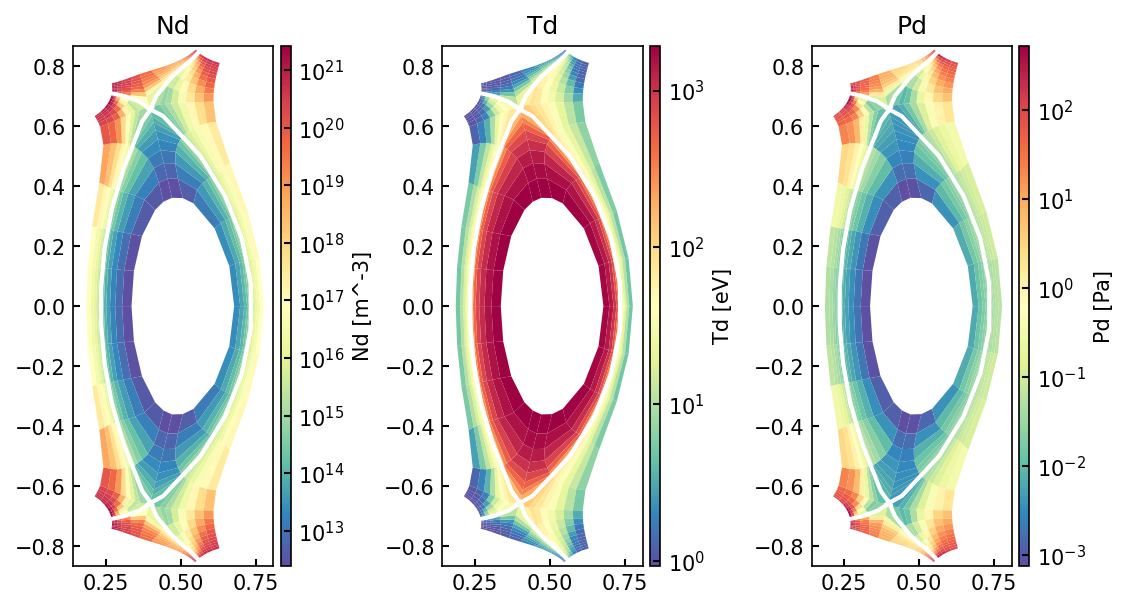

In [26]:
fig, axes = plt.subplots(1,3, figsize = (3.0*3,4.5), dpi = 150)
cmap = "Spectral_r"

name = "Nnorm_x10"

ds = cs[name].ds
if "t" in ds.sizes: ds = ds.isel(t=-1)

for i, param in enumerate(["Nd", "Td", "Pd"]):
  
  data = ds[param]
  ax = axes[i]
  data.hermesm.clean_guards().bout.polygon(ax = ax, cmap = cmap, targets = False, 
                                                        separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                        # colorbar_label="Test",
                                                        antialias = True,
                                                        logscale = True,
                                                        # vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                        )
  ax.set_title(param)
  ax.set_xlabel("")
  ax.set_ylabel("")